# Modélisation – Prédiction de l’urbanisation à Toulouse (2021)

Objectif : comparer plusieurs modèles de **classification binaire** pour prédire la variable cible **`urban_2021`**  
(0 = non-urbain, 1 = urbain), à partir de variables spectrales, géographiques et socio‑démographiques.


In [1]:
# Librairies standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Outils scikit-learn
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, average_precision_score
)

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Graine aléatoire pour la reproductibilité
RANDOM_STATE = 42


## 1) Chargement des données et définition de X / y

On charge le jeu de données, on supprime les colonnes techniques,
puis on sépare les variables explicatives `X` et la cible `y`.


In [2]:
CSV_PATH = "data/toulouse_urban_dataset_2021_v2.csv"
df = pd.read_csv(CSV_PATH)

# Suppression de colonnes techniques si elles existent
optional_drop = [c for c in ["system:index", ".geo", "class_2021"] if c in df.columns]
if optional_drop:
    df = df.drop(columns=optional_drop)

print("Shape:", df.shape)
print("Colonnes:", list(df.columns))
df.head()


Shape: (49903, 12)
Colonnes: ['NDBI', 'NDVI', 'NDWI', 'dist_center', 'dist_rail', 'dist_road', 'dist_water', 'lat', 'lon', 'pop_density', 'slope_deg', 'urban_2021']


,NDBI,NDVI,NDWI,dist_center,dist_rail,dist_road,dist_water,lat,lon,pop_density,slope_deg,urban_2021
0,0.092834,0.120724,-0.184476,2211.778215,237.065392,53.851648,671.863081,43.584604,1.444913,338.486847,0.927410,1
1,0.015782,0.123669,-0.208278,10770.422494,136.014705,72.111026,1220.163923,43.520126,1.378360,48.522186,3.059466,1
2,-0.011861,0.597159,-0.663193,10042.090839,2576.897359,0.000000,730.547740,43.551041,1.544248,58.361877,2.252424,0
3,-0.311915,0.610584,-0.553950,9176.318388,44.721360,0.000000,545.893763,43.531827,1.390030,48.583282,0.000000,1
4,0.044857,0.709651,-0.768456,11289.141726,1570.350279,50.000000,1073.312629,43.679470,1.349562,0.000000,5.284470,0


In [3]:
TARGET = "urban_2021"

# Matrice de caractéristiques et variable cible
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

print("X shape:", X.shape, "| y shape:", y.shape)


X shape: (49903, 11) | y shape: (49903,)


## 2) Split train / test

- Split **stratifié** pour conserver la proportion de classes.
- Le jeu de test est conservé pour l’évaluation finale uniquement.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("y_train mean:", y_train.mean().round(4), "| y_test mean:", y_test.mean().round(4))


Train: (34932, 11) Test: (14971, 11)
y_train mean: 0.4023 | y_test mean: 0.4023


## 3) Fonctions utilitaires d’évaluation

Fonctions génériques pour :
- récupérer un score continu (proba / score),
- calculer les métriques,
- tracer matrice de confusion, ROC et PR.


In [5]:
def get_scores(model, X):
    """Retourne un score continu pour ROC/PR :
    - probabilité si disponible,
    - sinon score de décision.
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None

def evaluate_on_test(model, X_test, y_test, model_name="model", plot=True):
    # Prédictions binaires
    y_pred = model.predict(X_test)
    # Scores continus (pour ROC / PR)
    y_score = get_scores(model, X_test)

    # Calcul des métriques principales
    metrics = {
        "model": model_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan,
        "avg_precision": average_precision_score(y_test, y_score) if y_score is not None else np.nan,
    }

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(ax=axes[0], values_format="d")
        axes[0].set_title(f"Confusion – {model_name}")

        # Courbe ROC
        if y_score is not None:
            RocCurveDisplay.from_predictions(y_test, y_score, ax=axes[1])
            axes[1].set_title(f"ROC – {model_name}")
        else:
            axes[1].axis("off")

        # Courbe Precision-Recall
        if y_score is not None:
            PrecisionRecallDisplay.from_predictions(y_test, y_score, ax=axes[2])
            axes[2].set_title(f"PR – {model_name}")
        else:
            axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return metrics


## 4) Baseline interprétable : régression logistique

Pipeline :
- standardisation des variables,
- régression logistique.
Les hyperparamètres sont ajustés par validation croisée.


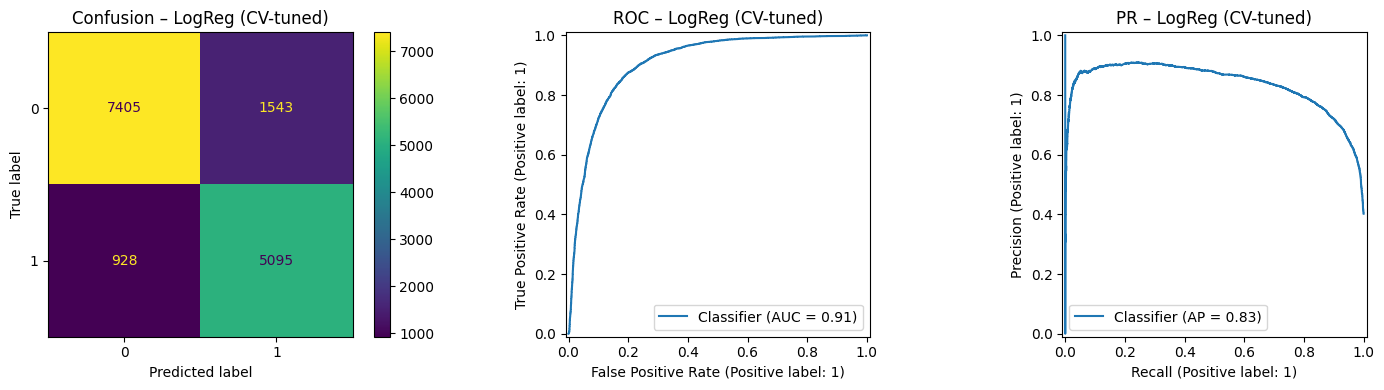

{'model': 'LogReg (CV-tuned)',
 'accuracy': 0.8349475652928996,
 'balanced_accuracy': 0.8367415946367416,
 'f1': 0.804833741410631,
 'roc_auc': 0.9075351407742531,
 'avg_precision': 0.8344630774370628}

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipe_logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=3000,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

param_grid_logreg = {
    "clf__C": [0.1, 1.0, 3.0, 10.0]
}

gs_logreg = GridSearchCV(
    pipe_logreg,
    param_grid_logreg,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

gs_logreg.fit(X_train, y_train)

best_logreg = gs_logreg.best_estimator_
m_logreg = evaluate_on_test(best_logreg, X_test, y_test, "LogReg (CV-tuned)", plot=True)
m_logreg


## 5) Arbre de décision

On compare :
- un arbre **contraint** (profondeur limitée),
- un arbre **non contraint** (potentiellement sur‑apprenant).


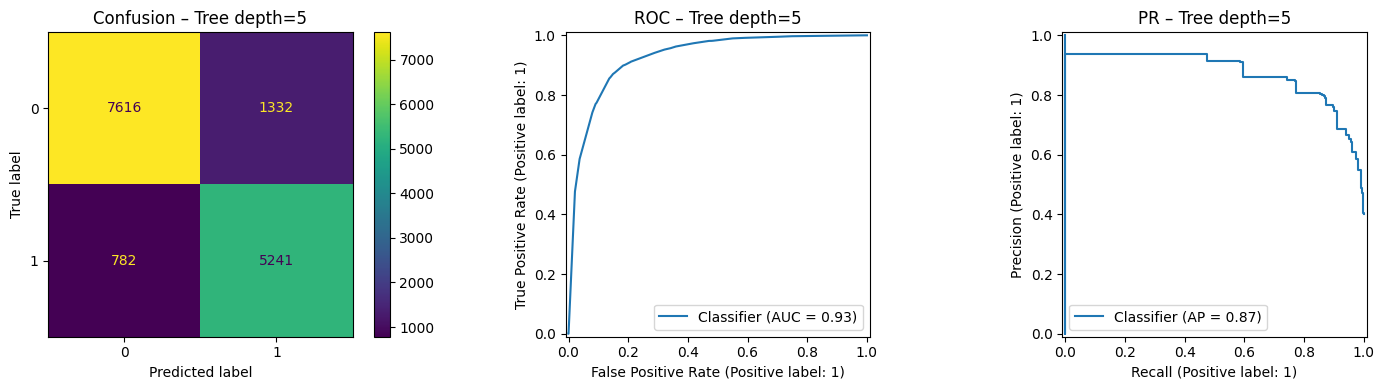

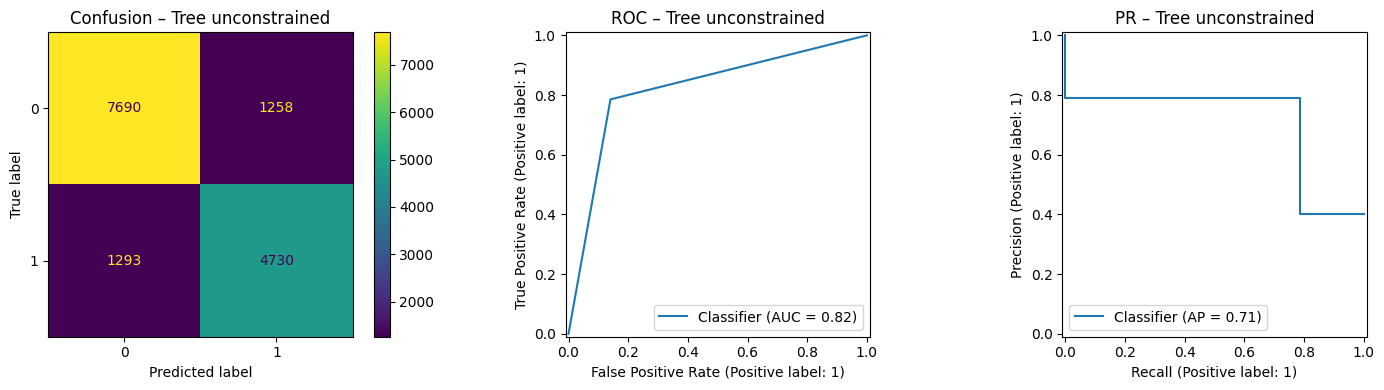

({'model': 'Tree depth=5',
  'accuracy': 0.8587936677576649,
  'balanced_accuracy': 0.8606521447252081,
  'f1': 0.8321689425214354,
  'roc_auc': 0.9272532794307858,
  'avg_precision': 0.8730050682030132},
 {'model': 'Tree unconstrained',
  'accuracy': 0.829603900875025,
  'balanced_accuracy': 0.8223664263892005,
  'f1': 0.7876113562567646,
  'roc_auc': 0.8223664263892004,
  'avg_precision': 0.706703892168671})

In [7]:
tree_shallow = DecisionTreeClassifier(
    max_depth=5,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

tree_deep = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

tree_shallow.fit(X_train, y_train)
tree_deep.fit(X_train, y_train)

m_tree_shallow = evaluate_on_test(tree_shallow, X_test, y_test, "Tree depth=5", plot=True)
m_tree_deep = evaluate_on_test(tree_deep, X_test, y_test, "Tree unconstrained", plot=True)

m_tree_shallow, m_tree_deep


### Effet de la profondeur (validation croisée)

On étudie l’effet de `max_depth` **sur le jeu d’entraînement uniquement**
à l’aide de la validation croisée.


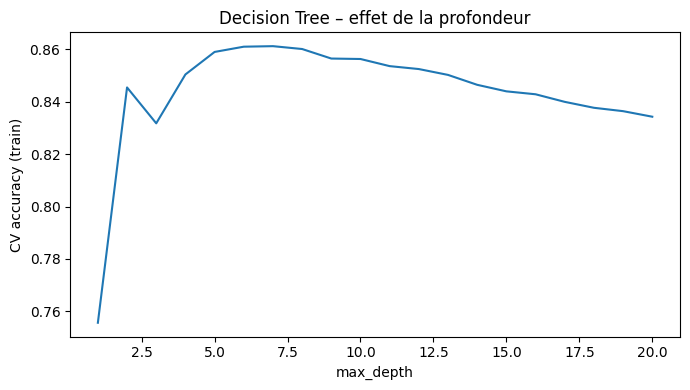

In [8]:
depths = list(range(1, 21))
rows = []

for d in depths:
    clf = DecisionTreeClassifier(
        max_depth=d,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    cv_acc = cross_val_score(
        clf, X_train, y_train,
        cv=cv, scoring="accuracy", n_jobs=-1
    )
    rows.append({
        "max_depth": d,
        "cv_acc_mean": cv_acc.mean(),
        "cv_acc_std": cv_acc.std()
    })

df_depth = pd.DataFrame(rows)

plt.figure(figsize=(7,4))
plt.plot(df_depth["max_depth"], df_depth["cv_acc_mean"])
plt.xlabel("max_depth")
plt.ylabel("CV accuracy (train)")
plt.title("Decision Tree – effet de la profondeur")
plt.tight_layout()
plt.show()


## 6) Random Forest

Méthode ensembliste basée sur l’agrégation de nombreux arbres.
Les hyperparamètres sont ajustés par validation croisée.


In [9]:
pipe_rf = Pipeline(steps=[
    ("clf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

param_grid_rf = {
    "clf__n_estimators": [300, 600],
    "clf__max_features": ["sqrt", 0.5],
    "clf__max_depth": [None, 12, 20],
    "clf__min_samples_leaf": [1, 3, 8],
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)

best_rf = gs_rf.best_estimator_
m_rf = evaluate_on_test(best_rf, X_test, y_test, "Random Forest (CV-tuned)", plot=True)
m_rf


/home/imane/Documents/ensae/StatisticalLearningProject/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

## 7) Gradient Boosting

Méthode de boosting : les arbres sont construits séquentiellement
pour corriger les erreurs précédentes.


In [ ]:
pipe_gb = Pipeline(steps=[
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

param_grid_gb = {
    "clf__n_estimators": [150, 300],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [2, 3],
    "clf__subsample": [1.0, 0.8],
}

gs_gb = GridSearchCV(
    pipe_gb,
    param_grid_gb,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

gs_gb.fit(X_train, y_train)

best_gb = gs_gb.best_estimator_
m_gb = evaluate_on_test(best_gb, X_test, y_test, "Gradient Boosting (CV-tuned)", plot=True)
m_gb


## 8) Réseau de neurones (MLP)

Réseau de neurones simple pour données tabulaires.
La standardisation est indispensable.


In [ ]:
pipe_mlp = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True
    ))
])

param_grid_mlp = {
    "clf__hidden_layer_sizes": [(64, 32), (128, 64)],
    "clf__alpha": [1e-4, 1e-3],
    "clf__learning_rate_init": [1e-3, 5e-4],
}

gs_mlp = GridSearchCV(
    pipe_mlp,
    param_grid_mlp,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

gs_mlp.fit(X_train, y_train)

best_mlp = gs_mlp.best_estimator_
m_mlp = evaluate_on_test(best_mlp, X_test, y_test, "MLP (CV-tuned)", plot=True)
m_mlp


## 9) Comparaison finale des modèles

Tableau récapitulatif des performances sur le **jeu de test**.


In [ ]:
results = pd.DataFrame([
    m_logreg,
    m_tree_shallow,
    m_tree_deep,
    m_rf,
    m_gb,
    m_mlp
]).set_index("model")

results.sort_values("roc_auc", ascending=False)


In [ ]:
plt.figure(figsize=(8,4))
results["roc_auc"].sort_values().plot(kind="barh")
plt.title("Comparaison ROC-AUC (test)")
plt.xlabel("ROC-AUC")
plt.tight_layout()
plt.show()
